In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
    median_absolute_error
)

In [7]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        distances, indices = tree.query(coords, k=k_neighbors + 1)
        
        # Convert distances to weights (inverse distance weighting)
        weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        return {
            'knn_price_mean': np.nanmean(neighbor_prices, axis=1),
            'knn_price_std': np.nanstd(neighbor_prices, axis=1),
            'knn_price_median': np.nanmedian(neighbor_prices, axis=1),
            'knn_price_range': np.ptp(neighbor_prices, axis=1),
            'price_diff_from_neighbors': chunk_data['price'].values - np.nanmean(neighbor_prices, axis=1),
            'distance_weighted_price': np.sum(weights * neighbor_prices, axis=1)
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            k_neighbors,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        spatial_features[col] = (spatial_features[col] - spatial_features[col].mean()) / spatial_features[col].std()
    
    return spatial_features

def evaluate_model_performance(y_true, y_pred, dates):
    """Evaluate model performance with temporal analysis."""
    results = {}
    
    # Traditional Metrics
    results['traditional'] = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    
    # Add new traditional metrics
    results['traditional'].update({
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    })
    
    # Create DataFrame for analysis
    df = pd.DataFrame({
        'date': dates,
        'true': y_true,
        'pred': y_pred,
        'error': y_true - y_pred,
        'abs_error': np.abs(y_true - y_pred),
        'pct_error': np.abs((y_true - y_pred) / y_true) * 100,
        'squared_error': (y_true - y_pred) ** 2
    })
    
    # Temporal Analysis
    monthly_metrics = df.set_index('date').resample('ME').agg({
        'abs_error': ['mean', 'std', 'median', 'min', 'max'],
        'pct_error': ['mean', 'std', 'median', 'min', 'max'],
        'squared_error': ['mean', 'std']
    })
    
    # Rolling metrics with multiple windows
    windows = [7, 14, 30]  # Weekly, bi-weekly, monthly
    rolling_metrics = {}
    for window in windows:
        rolling_metrics[f'{window}d'] = df.set_index('date').rolling(
            window=window, 
            min_periods=1
        ).agg({
            'abs_error': ['mean', 'std', 'median'],
            'pct_error': ['mean', 'std', 'median'],
            'squared_error': 'mean'
        })
    
    # Error autocorrelation
    # Inside evaluate_model_performance function
    # Calculate number of unique days in the dataset
    n_days = len(df['date'].unique())

    # Only calculate lags that make sense
    error_autocorr = {
        'lag1': df['error'].autocorr(lag=1),  # Daily lag
    }

    # Add weekly lag only if we have more than 7 days
    if n_days > 7:
        error_autocorr['lag7'] = df['error'].autocorr(lag=7)

    # Add biweekly lag only if we have more than 14 days
    if n_days > 14:
        error_autocorr['lag14'] = df['error'].autocorr(lag=14)
    
    results['temporal'] = {
        'monthly_metrics': monthly_metrics,
        'rolling_metrics': rolling_metrics,
        'error_autocorr': error_autocorr
    }
    
    # Empty spatial results for plotting compatibility
    results['spatial'] = pd.DataFrame(
        columns=['distance_band', 'mean_error_diff', 'std_error_diff', 'n_samples']
    )
    
    return results

def create_evaluation_plots(results):
    """Create visualization plots for the evaluation results."""
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Create figure with subplots (2 or 3 depending on spatial analysis)
    has_spatial = not results['spatial'].empty
    n_plots = 3 if has_spatial else 2
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots))
    
    # Plot 1: Rolling Error Metrics
    rolling_metrics = results['temporal']['rolling_metrics']['30d']  # Using 30-day window
    weekly_means = rolling_metrics['abs_error']['mean'].resample('W').mean()
    weekly_stds = rolling_metrics['abs_error']['std'].resample('W').mean()
    
    color = sns.color_palette("husl", 8)[0]
    sns.lineplot(x=weekly_means.index, y=weekly_means,
                label='Weekly MAE', ax=axes[0],
                color=color, linewidth=2)
    
    axes[0].fill_between(
        weekly_means.index,
        weekly_means - weekly_stds,
        weekly_means + weekly_stds,
        alpha=0.2,
        color=color
    )
    
    sns.despine(ax=axes[0])
    axes[0].set_title('Weekly Mean Absolute Error with Standard Deviation',
                     pad=20, fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=10)
    axes[0].set_ylabel('Error', fontsize=10)
    
    # Plot 2: Monthly Error Patterns
    monthly_data = results['temporal']['monthly_metrics']
    months = monthly_data.index.strftime('%Y-%m')
    monthly_plot_data = pd.DataFrame({
        'Month': months,
        'Mean Error': monthly_data['abs_error']['mean'],
        'Std Error': monthly_data['abs_error']['std']
    })
    
    sns.barplot(data=monthly_plot_data,
                x='Month',
                y='Mean Error',
                ax=axes[1],
                color=sns.color_palette("husl", 8)[1])
    
    axes[1].errorbar(x=range(len(months)),
                    y=monthly_plot_data['Mean Error'],
                    yerr=monthly_plot_data['Std Error'],
                    fmt='none',
                    color='black',
                    capsize=5)
    
    sns.despine(ax=axes[1])
    axes[1].set_title('Monthly Error Patterns',
                     pad=20, fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Month', fontsize=10)
    axes[1].set_ylabel('Mean Absolute Error', fontsize=10)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Spatial Error Analysis (if available)
    if has_spatial:
        valid_bands = results['spatial']
        
        sns.barplot(data=valid_bands,
                   x='distance_band',
                   y='mean_error_diff',
                   ax=axes[2],
                   color=sns.color_palette("husl", 8)[2])
        
        axes[2].errorbar(x=range(len(valid_bands)),
                        y=valid_bands['mean_error_diff'],
                        yerr=valid_bands['std_error_diff'],
                        fmt='none',
                        color='black',
                        capsize=5)
        
        for i, row in valid_bands.iterrows():
            axes[2].text(i, row['mean_error_diff'],
                        f'n={row["n_samples"]}',
                        ha='center', va='bottom',
                        fontsize=9)
        
        sns.despine(ax=axes[2])
        axes[2].set_title('Error Differences by Distance Band',
                         pad=20, fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Distance Band', fontsize=10)
        axes[2].set_ylabel('Mean Error Difference', fontsize=10)
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

In [3]:
# Load preprocessed data
print("Loading preprocessed data...")
train_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\train_data_2024.csv')
test_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\test_data_2025.csv')
print("Data loaded successfully.")

# # Reduce the number of listings to 500 for testing and development
# train_data = train_data.sample(n=1000, random_state=42)
# test_data = test_data.sample(n=500, random_state=42)
# print("Reduced the number of listings to 500 for testing and development.")

Loading preprocessed data...
Data loaded successfully.


In [4]:
# Add spatial features
print("Creating spatial features for training data...")
train_spatial = create_spatial_features(train_data)
print("Spatial features for training data created.")

print("Creating spatial features for test data...")
test_spatial = create_spatial_features(test_data)
print("Spatial features for test data created.")

# Combine with existing features
print("Combining spatial features with existing features...")
X_train = pd.concat([train_data.drop(['listing_id', 'date', 'price'], axis=1), train_spatial], axis=1)
X_test = pd.concat([test_data.drop(['listing_id', 'date', 'price'], axis=1), test_spatial], axis=1)
print("Features combined.")

y_train = train_data['price']
y_test = test_data['price']
test_dates = pd.to_datetime(test_data['date'])

Creating spatial features for training data...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Spatial features for training data created.
Creating spatial features for test data...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Spatial features for test data created.
Combining spatial features with existing features...
Features combined.


In [5]:
# Now the execution part
if __name__ == "__main__":
    # Initialize and train XGBoost model
    print("Initializing XGBoost model...")
    xgb_model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    print("XGBoost model initialized.")

    # Train model and make predictions
    print("Training XGBoost model...")
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    print("Model training completed.")

    print("Making predictions on test data...")
    y_pred = xgb_model.predict(X_test)
    print("Predictions completed.")

    # Evaluate model performance
    print("Evaluating model performance...")
    evaluation_results = evaluate_model_performance(y_test, y_pred, test_dates)

Initializing XGBoost model...
XGBoost model initialized.
Training XGBoost model...
[0]	validation_0-rmse:1.00727
[1]	validation_0-rmse:0.99727
[2]	validation_0-rmse:0.98739
[3]	validation_0-rmse:0.97769
[4]	validation_0-rmse:0.96798
[5]	validation_0-rmse:0.95838
[6]	validation_0-rmse:0.94886
[7]	validation_0-rmse:0.93944
[8]	validation_0-rmse:0.93011
[9]	validation_0-rmse:0.92086
[10]	validation_0-rmse:0.91176
[11]	validation_0-rmse:0.90279
[12]	validation_0-rmse:0.89382
[13]	validation_0-rmse:0.88495
[14]	validation_0-rmse:0.87626
[15]	validation_0-rmse:0.86768
[16]	validation_0-rmse:0.85910
[17]	validation_0-rmse:0.85062
[18]	validation_0-rmse:0.84218
[19]	validation_0-rmse:0.83392
[20]	validation_0-rmse:0.82567
[21]	validation_0-rmse:0.81750
[22]	validation_0-rmse:0.80942
[23]	validation_0-rmse:0.80150
[24]	validation_0-rmse:0.79366
[25]	validation_0-rmse:0.78581
[26]	validation_0-rmse:0.77803
[27]	validation_0-rmse:0.77035
[28]	validation_0-rmse:0.76282
[29]	validation_0-rmse:0.755

Evaluating model performance...

=== Traditional Performance Metrics ===
R² Score: 0.9924
Mean Absolute Error: 0.0321
Root Mean Squared Error: 0.0886
Mean Absolute Percentage Error: 8.8226%
Explained Variance: 0.9925
Max Error: 3.0926
Median Absolute Error: 0.0167

=== Temporal Analysis ===

Monthly Metrics:

Mean Absolute Error by Month:
date
2025-04-30    0.031984
2025-05-31    0.032153
Freq: ME, Name: mean, dtype: float64

Standard Deviation of Absolute Error by Month:
date
2025-04-30    0.082303
2025-05-31    0.082783
Freq: ME, Name: std, dtype: float64

Mean Percentage Error by Month:
date
2025-04-30    8.801175
2025-05-31    8.843423
Freq: ME, Name: mean, dtype: float64

Standard Deviation of Percentage Error by Month:
date
2025-04-30    40.404563
2025-05-31    40.665790
Freq: ME, Name: std, dtype: float64

=== Error Autocorrelation Analysis ===
Daily (lag 1): 0.9841
Weekly (lag 7): 0.8884
Monthly (lag 14): 0.7775

=== Rolling Metrics Summary ===

7d Window Statistics:
Mean Absol

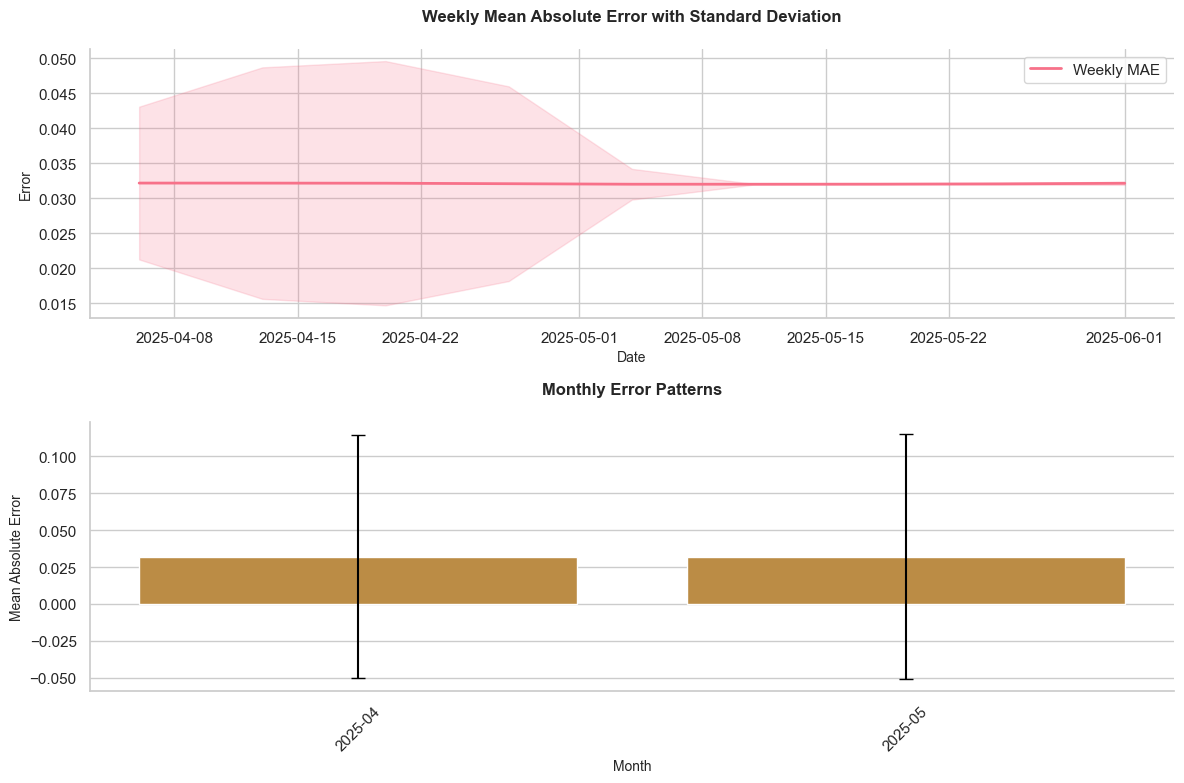


=== Feature Importance Analysis ===

Top 10 Most Important Features:
                    feature  importance
12         rolling_mean_30d    0.366871
14          rolling_max_30d    0.275277
15          rolling_min_30d    0.107718
19          rolling_min_60d    0.047268
16         rolling_mean_60d    0.045609
31  distance_weighted_price    0.038652
18          rolling_max_60d    0.032283
22          rolling_max_90d    0.026160
26           knn_price_mean    0.021416
29         knn_price_median    0.013738

=== Monthly Performance Breakdown ===

Detailed Monthly Performance:
              true abs_error         pct_error         
             count      mean     std      mean      std
date                                                   
2025-04-30  600000    0.0320  0.0823    8.8012  40.4046
2025-05-31  620000    0.0322  0.0828    8.8434  40.6658


In [9]:
# Main evaluation code
print("Evaluating model performance...")
evaluation_results = evaluate_model_performance(y_test, y_pred, test_dates)

# Traditional Metrics
print("\n=== Traditional Performance Metrics ===")
print(f"R² Score: {evaluation_results['traditional']['r2']:.4f}")
print(f"Mean Absolute Error: {evaluation_results['traditional']['mae']:.4f}")
print(f"Root Mean Squared Error: {evaluation_results['traditional']['rmse']:.4f}")
print(f"Mean Absolute Percentage Error: {evaluation_results['traditional']['mape']:.4f}%")
print(f"Explained Variance: {evaluation_results['traditional']['explained_variance']:.4f}")
print(f"Max Error: {evaluation_results['traditional']['max_error']:.4f}")
print(f"Median Absolute Error: {evaluation_results['traditional']['median_absolute_error']:.4f}")

# Temporal Analysis
print("\n=== Temporal Analysis ===")
print("\nMonthly Metrics:")
monthly_metrics = evaluation_results['temporal']['monthly_metrics']
print("\nMean Absolute Error by Month:")
print(monthly_metrics['abs_error']['mean'])
print("\nStandard Deviation of Absolute Error by Month:")
print(monthly_metrics['abs_error']['std'])
print("\nMean Percentage Error by Month:")
print(monthly_metrics['pct_error']['mean'])
print("\nStandard Deviation of Percentage Error by Month:")
print(monthly_metrics['pct_error']['std'])

# Error Autocorrelation
print("\n=== Error Autocorrelation Analysis ===")
error_autocorr = evaluation_results['temporal']['error_autocorr']
print(f"Daily (lag 1): {error_autocorr['lag1']:.4f}")
print(f"Weekly (lag 7): {error_autocorr['lag7']:.4f}")
print(f"Monthly (lag 14): {error_autocorr['lag14']:.4f}")

# Rolling Metrics Summary
print("\n=== Rolling Metrics Summary ===")
rolling_metrics = evaluation_results['temporal']['rolling_metrics']

# Print for each window
for window in ['7d', '14d', '30d']:
    metrics = rolling_metrics[window]
    print(f"\n{window} Window Statistics:")
    print("Mean Absolute Error:")
    print(f"  Average: {metrics['abs_error']['mean'].mean():.4f}")
    print(f"  Min: {metrics['abs_error']['mean'].min():.4f}")
    print(f"  Max: {metrics['abs_error']['mean'].max():.4f}")
    print("Percentage Error:")
    print(f"  Average: {metrics['pct_error']['mean'].mean():.4f}%")
    print(f"  Min: {metrics['pct_error']['mean'].min():.4f}%")
    print(f"  Max: {metrics['pct_error']['mean'].max():.4f}%")

# Create visualization plots
print("\nGenerating evaluation plots...")
create_evaluation_plots(evaluation_results)

# Feature importance analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Monthly performance breakdown
print("\n=== Monthly Performance Breakdown ===")
results_df = pd.DataFrame({
    'date': test_dates,
    'true': y_test,
    'pred': y_pred,
    'abs_error': np.abs(y_test - y_pred),
    'pct_error': np.abs((y_test - y_pred) / y_test) * 100
})

# Group by month and calculate metrics
monthly_performance = results_df.set_index('date').resample('ME').agg({
    'true': 'count',
    'abs_error': ['mean', 'std'],
    'pct_error': ['mean', 'std']
}).round(4)

print("\nDetailed Monthly Performance:")
print(monthly_performance)